**(a)**

In [1]:
import torchvision as thv
import numpy as np
import cv2
import matplotlib.pyplot as plt

train = thv.datasets.MNIST ('./', download =True , train =True)
val = thv.datasets.MNIST ('./', download =True , train = False )

train_data, train_target, val_data, val_target = train.data.numpy(), train.targets.numpy(), val.data.numpy(), val.targets.numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 52010857.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11791657.14it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25739295.83it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13406424.19it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train = np.column_stack((train_data.reshape(60000,784),train_target))[(train_target == 0) | (train_target == 1)]
val = np.column_stack((val_data.reshape(10000,784),val_target))[(val_target) == 0 | (val_target == 1)]
train_data = []
train_target = []
val_data = []
val_target = []
np.random.shuffle(train)
np.random.shuffle(val)
for i in range(len(train)):
  train_data.append(cv2.resize(train[i][:-1].reshape(28,28).astype('float32'),(14,14)))
  train_target.append(train[i][-1])
for i in range(len(val)):
  val_data.append(cv2.resize(val[i][:-1].reshape(28,28).astype('float32'),(14,14)))
  val_target.append(val[i][-1])
train_data, train_target, val_data, val_target = np.array(train_data), np.array(train_target), np.array(val_data), np.array(val_target)
train_data = train_data.reshape(train_data.shape[0],196) / 255
val_data = val_data.reshape(val_data.shape[0],196) / 255
train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))
val_data = np.hstack((val_data, np.ones((val_data.shape[0], 1))))
train_target = np.where(train_target == 0, 1, -1)
val_target = np.where(val_target == 0, 1, -1)

**(b)**

In [ ]:
def logistic_loss(X, y, w, w_0, lam):
  z = y * (np.dot(X, w) + w_0)
  loss = np.log(1 + np.exp(-z))
  reg_term = 0.5 * lam * (np.linalg.norm(w) ** 2 + w_0 ** 2)
  return np.mean(loss) + reg_term


def gradient(X, y, w, w_0, lam):
  n = len(y)
  z = y * (np.dot(X, w) + w_0)
  sigmoid = 1 / (1 + np.exp(z))
  grad_w = -np.dot(X.T, y * sigmoid) / n + lam * w
  grad_w0 = -np.mean(y * sigmoid) + lam * w_0
  return grad_w, grad_w0


def gradient_descent(X, y, val_X, val_y, learning_rate, num_epochs, lam):
  np.random.seed(42)
  n, d = X.shape
  w = np.random.randn(d)
  w_0 = np.random.randn()
  losses = []
  for epoch in range(num_epochs):
    grad_w, grad_w0 = gradient(X, y, w, w_0, lam)
    w -= learning_rate * grad_w
    w_0 -= learning_rate * grad_w0
    loss = logistic_loss(X, y, w, w_0, lam)
    losses.append(loss)
  val_losses = logistic_loss(val_X, val_y, w, w_0, lam)

  return losses, val_losses

lambda 0.01 slope:  -0.007944918323922958
lambda 0.01 validation loss:  2.7784032849238924 

lambda 0.1 slope:  -0.004659582737620368
lambda 0.1 validation loss:  9.499939910356225 

lambda 1 slope:  -0.02042714738933829
lambda 1 validation loss:  32.082298583462986 

lambda 10 slope:  -0.2104792714503868
lambda 10 validation loss:  0.6802403236787742 

lambda 20 slope:  -0.44366474544919776
lambda 20 validation loss:  0.6746973622768997 

lambda 30 slope:  -0.6891485950881135
lambda 30 validation loss:  0.6806447446154121 

lambda 40 slope:  -0.8539737988237647
lambda 40 validation loss:  0.6836916955624481 

lambda 50 slope:  -0.8487579382518802
lambda 50 validation loss:  0.6855442967436178 



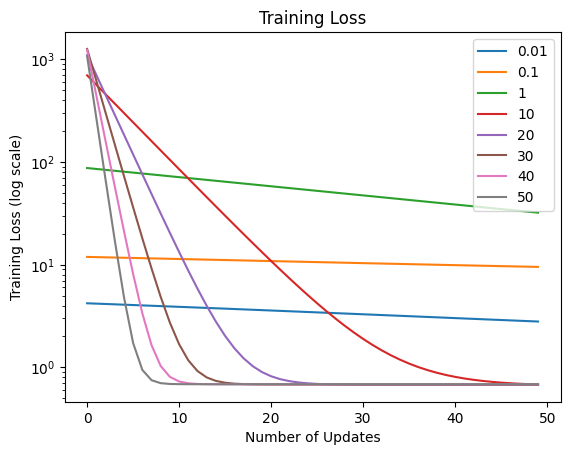

In [ ]:
learning_rate = 0.01
num_epochs = 50
lambdas = [0.01,0.1,1,10,20,30,40,50]


for l in lambdas:
  train_loss, val_loss = gradient_descent(train_data, train_target, val_data, val_target, learning_rate, num_epochs, l)
  print("lambda", l ,"slope: ", np.polyfit(range(10),np.log(train_loss[:10]),1)[0])
  print("lambda", l,"validation loss: ", val_loss,"\n")
  plt.semilogy(train_loss)
plt.legend(('0.01', '0.1', '1', '10', '20', '30', '40', '50'))
plt.xlabel('Number of Updates')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Loss')
plt.show()

**(d)**

In [ ]:
def nesterov(X, y, val_X, val_y, learning_rate, num_epochs, lam, rho):
  np.random.seed(42)
  n, d = X.shape
  w = np.random.randn(d)
  w_0 = np.random.randn()
  w_prev = np.random.randn(d)
  w_0_prev = np.random.randn()
  losses = []
  for epoch in range(num_epochs):
    u = (1+rho)*w - rho*w_prev
    u_0 = (1+rho)*w_0 - rho*w_0_prev
    grad_w, grad_w_0 = gradient(X, y, u, u_0, lam)
    w_next = u - learning_rate * grad_w
    w_0_next = u_0 - learning_rate * grad_w_0
    w_prev = w
    w_0_prev = w_0
    w = w_next
    w_0 = w_0_next
    loss = logistic_loss(X, y, w, w_0, lam)
    losses.append(loss)

  val_losses = logistic_loss(val_X, val_y, w, w_0, lam)
  return losses, val_losses

Rho 0.75 slope:  -0.39131475607490274
Rho 0.75 validation loss:  0.6579618910799027 

Rho 0.8 slope:  -0.3620855888604553
Rho 0.8 validation loss:  0.6581596417687164 

Rho 0.85 slope:  -0.3214317408705285
Rho 0.85 validation loss:  0.6586630590461519 

Rho 0.9 slope:  -0.27044553278405203
Rho 0.9 validation loss:  0.7168198932163347 

Rho 0.95 slope:  -0.21841253707530248
Rho 0.95 validation loss:  2.2877178770270064 



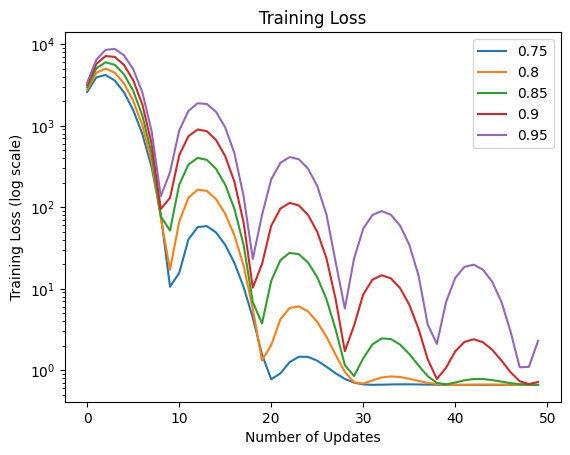

In [ ]:
rhos = [0.75,0.8,0.85,0.9,0.95]
for rho in rhos:
  train_loss, val_loss = nesterov(train_data, train_target, val_data, val_target, learning_rate, num_epochs, 10, rho)
  print("Rho", rho ,"slope: ", np.polyfit(range(20),np.log(train_loss[:20]),1)[0])
  print("Rho", rho,"validation loss: ", val_loss,"\n")
  plt.semilogy(train_loss)
plt.legend(('0.75','0.8','0.85','0.9','0.95'))
plt.xlabel('Number of Updates')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Loss')
plt.show()

**(e)**

lambda 10 slope:  -0.09139011019536085
lambda 10 validation loss:  0.6803840912857312 



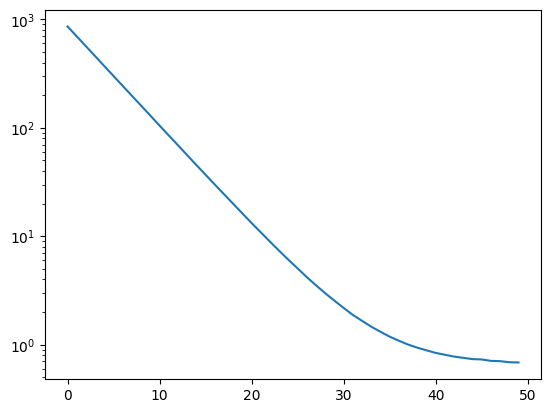

In [ ]:
def sgd(X, y, val_X, val_y, learning_rate, num_epochs, lam):
  np.random.seed(42)
  n, d = X.shape
  w = np.random.randn(d)
  w_0 = np.random.randn()
  losses = []
  batch_loss = []
  for epoch in range(num_epochs):
    indices = np.random.permutation(n)
    X_shuffled = X[indices][:128]
    y_shuffled = y[indices][:128]
    loss = logistic_loss(X_shuffled, y_shuffled, w, w_0, lam)
    grad_w, grad_w0 = gradient(X_shuffled, y_shuffled, w, w_0, lam)
    w -= learning_rate * grad_w
    w_0 -= learning_rate * grad_w0
    losses.append(loss)
  val_losses = logistic_loss(val_X, val_y, w, w_0, lam)

  return losses, val_losses

train_loss, val_loss = sgd(train_data, train_target, val_data, val_target, learning_rate, num_epochs, 10)
print("lambda", 10 ,"slope: ", np.polyfit(range(10),np.log10(train_loss[:10]),1)[0])
print("lambda", 10,"validation loss: ", val_loss,"\n")
plt.semilogy(train_loss)

Rho 0.75 slope:  -0.34997818487019666
Rho 0.75 validation loss:  0.6580416839395056 



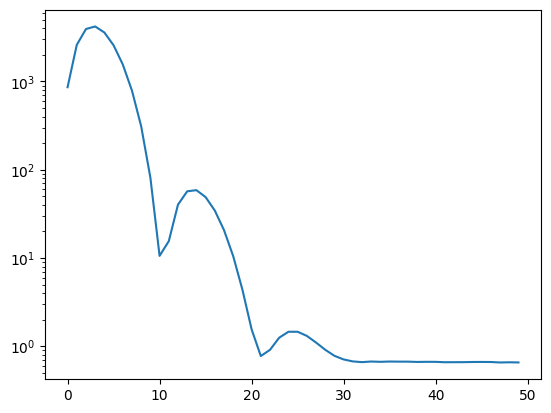

In [ ]:
def sgd_nesterov(X, y, val_X, val_y, learning_rate, num_epochs, lam, rho):
  np.random.seed(42)
  n, d = X.shape
  w = np.random.randn(d)
  w_0 = np.random.randn()
  w_prev = np.random.randn(d)
  w_0_prev = np.random.randn()
  losses = []
  batch_loss = []
  for epoch in range(num_epochs):
    indices = np.random.permutation(n)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    u = (1+rho)*w - rho*w_prev
    u_0 = (1+rho)*w_0 - rho*w_0_prev
    X_batch = X_shuffled[:128]
    y_batch = y_shuffled[:128]
    loss = logistic_loss(X_batch, y_batch, w, w_0, lam)
    grad_w, grad_w_0 = gradient(X_batch, y_batch, u, u_0, lam)
    w_next = u - learning_rate * grad_w
    w_0_next = u_0 - learning_rate * grad_w_0
    batch_loss.append(loss)
    w_prev = w
    w_0_prev = w_0
    w = w_next
    w_0 = w_0_next
    losses.append(loss)

  val_losses = logistic_loss(val_X, val_y, w, w_0, lam)
  return losses, val_losses

train_loss, val_loss = sgd_nesterov(train_data, train_target, val_data, val_target, learning_rate, num_epochs, 10, 0.75)
print("Rho", 0.75 ,"slope: ", np.polyfit(range(20),np.log(train_loss[:20]),1)[0])
print("Rho", 0.75,"validation loss: ", val_loss,"\n")
plt.semilogy(train_loss)

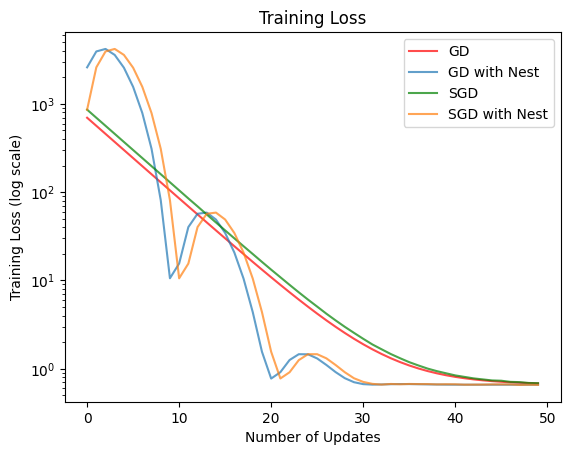

In [ ]:
lam = 10
learning_rate = 0.01
num_epochs = 50
rho = 0.75
train_loss_gd, val_loss_gd = gradient_descent(train_data, train_target, val_data, val_target, learning_rate, num_epochs, lam)
train_loss_nest, val_loss_nest = nesterov(train_data, train_target, val_data, val_target, learning_rate, num_epochs, lam, rho)
train_loss_sgd, val_loss_sgd = sgd(train_data, train_target, val_data, val_target, learning_rate, num_epochs, lam)
train_loss_sgd_nest, val_loss_sgd_nest = sgd_nesterov(train_data, train_target, val_data, val_target, learning_rate, num_epochs, lam, rho)

plt.semilogy(train_loss_gd, alpha=0.7, color='red')
plt.semilogy(train_loss_nest, alpha=0.7)
plt.semilogy(train_loss_sgd, alpha=0.7, color='green')
plt.semilogy(train_loss_sgd_nest, alpha=0.7)
plt.legend(('GD','GD with Nest','SGD','SGD with Nest') )
plt.xlabel('Number of Updates')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Loss')
plt.show()